# Setup

In [1]:
!nvidia-smi

Sat Apr 20 15:58:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   24C    P0              61W / 400W |   4312MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pwd

/blue/daisyw/smaley/test/gan/src


In [3]:
!which python

/blue/daisyw/smaley/test/gan/env/envs/deep_3.9/bin/python


In [4]:
# from PIL import Image
# import io
# import os

# reldir = "./../input/sprites"

# for subdir, dirs, files in os.walk(reldir):
#   for file in files:
#     # print(file)
#     try: # test loading images, remove images that cause errors
#       byteImg = Image.open(f"{reldir}/{file}").tobytes()
#       dataBytesIO = io.BytesIO(byteImg)
#     except:
#       print(file)
#       cmd = f"rm {reldir}/{file}"
#       os.system(cmd)

# GAN with pokemon sprites
images from https://drive.google.com/file/d/13n25zpzjLKythxH2A17UxHc36DLrDqnA/view

using code from https://github.com/jkleiber/PokeGAN


## Loading and augmenting pokemon dataset

In [27]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [28]:
IMAGE_DIR = "./../input"
image_size = 64
batch_size = 2400
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [29]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

dataset_list = [normal_dataset, mirror_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, num_workers=4, shuffle=True, pin_memory=False) # num_workers=4

In [30]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [31]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


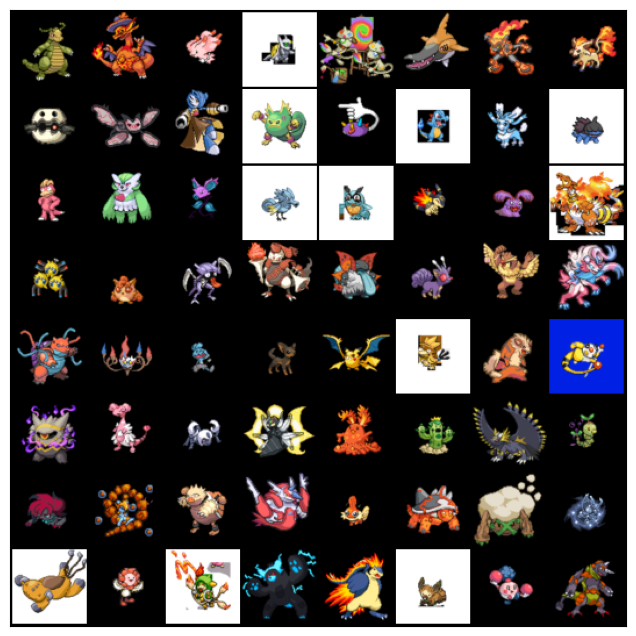

In [33]:
show_batch(dataloader)

## Discriminators

In [34]:
import torch.nn as nn

In [36]:
disc_64_2 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4

    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

## Generators

In [37]:
seed_size = 16

In [39]:
gen_64_2 = nn.Sequential(
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
)

## Test

In [40]:
test_model_size = False

if test_model_size:
    seed_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    generator=gen_64_1
    to_device(generator, device)
    fake_pokemon = generator(seed_batch)
    print(fake_pokemon.size())

In [41]:
def get_training_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for b in self.dataloader:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dataloader)

In [42]:
device = get_training_device()
device

device(type='cuda')

In [43]:
dev_dataloader = DeviceDataLoader(dataloader, device)

## Discriminator

In [44]:
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    real_predictions = discriminator(real_pokemon)
    
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) 
    real_score = torch.mean(real_predictions).item() 

    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)

    fake_pokemon = generator(latent_batch)

    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item()

    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [45]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()

    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)

    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss = F.binary_cross_entropy(disc_predictions, targets)
    
    loss.backward()
    gen_optimizer.step()

    return loss.item()

## Results Viewer

In [46]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [47]:
def save_results(index, latent_batch, show=True):
    fake_pokemon = generator(latent_batch)
    fake_file = "result-image-{0:0=4d}.png".format(index)
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

# Full Training

In [48]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()

    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []

    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))

    for epoch in range(50, epochs):
        for real_img, _ in tqdm(dev_dataloader):
          try:
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            gen_loss = train_generator(gen_optimizer)
          except Exception as e:
            print(f"Exception at epoch {epoch}:\n",e)

        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)

        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))

        save_results(epoch + start_idx, fixed_latent_batch, show=False)

        if (epoch % 25 == 0):
            torch.save({
                    'epoch': epoch,
                    'discriminator_state_dict': discriminator.state_dict(),
                    'generator_state_dict': generator.state_dict(),
                    'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                    'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                    'disc_losses': disc_losses,
                    'disc_scores': disc_scores,
                    'gen_losses': gen_losses,
                    'gen_scores': gen_scores
                }, f'checkpoint_epoch_{epoch + start_idx}.pt')

    return disc_losses, disc_scores, gen_losses, gen_scores

## Selecting Models
Here, I select the models I want to send to the GPU

In [49]:
discriminator = disc_64_2
discriminator = to_device(discriminator, device)

In [50]:
generator = gen_64_2
generator = to_device(generator, device)

In [51]:
checkpoint = torch.load('checkpoint_epoch_101.pt')
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

<All keys matched successfully>

## Training
Here I'll edit hyperparameters and train the GAN

In [27]:
learning_rate = 0.00275
epochs = 1000

In [161]:
history = train(epochs, learning_rate)

  0%|          | 0/111 [00:00<?, ?it/s]

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

Exception at epoch 50:
 DataLoader worker (pid 1939195) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.


RuntimeError: DataLoader worker (pid(s) 1939195) exited unexpectedly

# Viewing results

/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/baiyang94/daisyw/baiyang94/projects/ecole/envs/deep_3.9/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


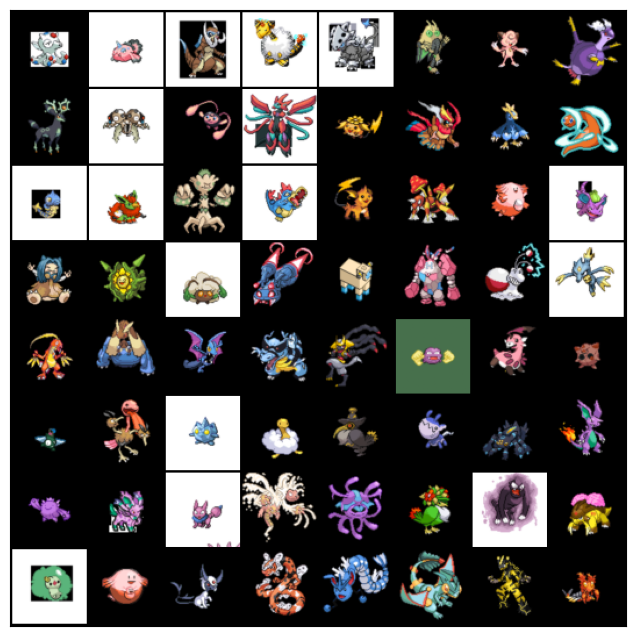

In [52]:
show_batch(dataloader)

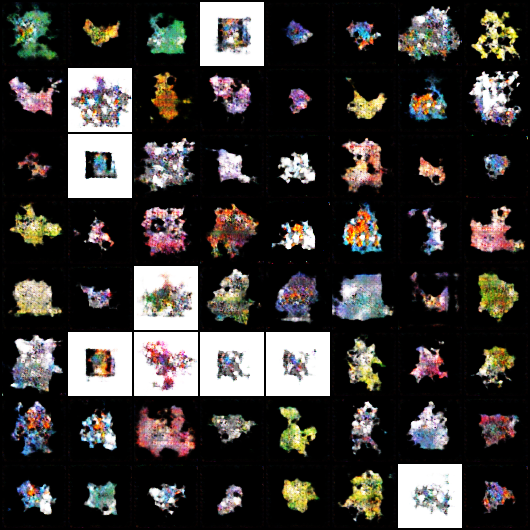

In [54]:
from IPython.display import Image
Image('./results/result-image-0108.png')